In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors


# Реализация класса

In [22]:

warnings.filterwarnings("ignore", category=UserWarning)


class DBSCAN:
    def __init__(self, eps=0.15, min_samples=10):
        self.eps = eps
        self.min_samples = min_samples
        self.labels_ = None

    def fit(self, X):
        n_points = X.shape[0]
        self.labels_ = np.full(n_points, -1)
        visited = np.zeros(n_points, dtype=bool)
        cluster_id = 0

        for point_idx in range(n_points):
            if not visited[point_idx]:
                visited[point_idx] = True
                neighbors = self._region_query(X, point_idx)
                if len(neighbors) < self.min_samples:
                    self.labels_[point_idx] = -1
                else:
                    self._expand_cluster(X, point_idx, neighbors, cluster_id, visited)
                    cluster_id += 1
        return self

    def _region_query(self, X, point_idx):
        distances = np.linalg.norm(X - X[point_idx], axis=1)
        return np.where(distances <= self.eps)[0]

    def _expand_cluster(self, X, point_idx, neighbors, cluster_id, visited):
        self.labels_[point_idx] = cluster_id
        i = 0
        while i < len(neighbors):
            neighbor_idx = neighbors[i]
            if not visited[neighbor_idx]:
                visited[neighbor_idx] = True
                neighbor_neighbors = self._region_query(X, neighbor_idx)
                if len(neighbor_neighbors) >= self.min_samples:
                    neighbors = np.concatenate((neighbors, neighbor_neighbors))
            if self.labels_[neighbor_idx] == -1:
                self.labels_[neighbor_idx] = cluster_id
            i += 1

# Реализации функции генерации данных

In [64]:

def generate_data():
    X1, y1 = make_moons(n_samples=300, noise=0.05, random_state=42)
    theta = np.pi / 2
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    X2 = (X1 @ R.T) + np.array([1, 2])  # Ближе друг к другу
    y2 = y1 + 3
    X_2d = np.vstack((X1, X2))
    y_true_2d = np.concatenate((y1, y2))

    X_temp, y_temp = make_moons(n_samples=300, noise=0.05, random_state=42)
    z = np.random.normal(scale=0.2, size=(X_temp.shape[0], 1))  # Больше шума в 3D
    X_3d = np.hstack((X_temp, z))
    y_true_3d = y_temp

    return X_2d, y_true_2d, X_3d, y_true_3d


# Поиск оптимального кол-ва кластеров через локоть - силует

In [67]:
def find_optimal_k(X):
    distortions = []
    silhouette_scores = []
    K = range(2, 10)

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
        distortions.append(kmeans.inertia_)

        if len(set(kmeans.labels_)) > 1:
            silhouette_scores.append(silhouette_score(X, kmeans.labels_))
        else:
            silhouette_scores.append(np.nan)

    inertia_diff = np.diff(distortions)
    inertia_diff2 = np.diff(inertia_diff)
    elbow_k = K[np.argmin(inertia_diff2) + 1]

    best_silhouette_k = K[np.nanargmax(silhouette_scores)]

    fig, ax1 = plt.subplots(figsize=(7, 5))
    ax2 = ax1.twinx()

    ax1.plot(K, distortions, 'bo-', label='Инерция')
    ax2.plot(K, silhouette_scores, 'ro-', label='Силуутный коэффициент')

    ax1.set_xlabel('Число кластеров')
    ax1.set_ylabel('Инерция', color='b')
    ax2.set_ylabel('Силуут', color='r')

    ax2.axvline(x=elbow_k, linestyle='--', color='blue', alpha=0.7, label=f'Локоть ({elbow_k})')
    ax2.axvline(x=best_silhouette_k, linestyle='--', color='red', alpha=0.7, label=f'Силуут ({best_silhouette_k})')

    plt.title(f'Метод локтя и силуэтный анализ')
    fig.legend(loc="upper right")

    plt.show()

    # optimal_k = min(elbow_k, best_silhouette_k)
    optimal_k = round((elbow_k + best_silhouette_k) / 2)
    print(f'Локоть инерции: {elbow_k}, Оптимальный силуэт: {best_silhouette_k}')
    print(f'Выбрано оптимальное число кластеров: {optimal_k}')

    return optimal_k

# Кластеризация


In [70]:

def clustering(X_2d, X_3d, optimal_k):

    dbscan_2d = DBSCAN(eps=0.3, min_samples=10).fit(X_2d)
    labels_2d = dbscan_2d.labels_
    dbscan_3d = DBSCAN(eps=0.3, min_samples=10).fit(X_3d)
    labels_3d = dbscan_3d.labels_

    kmeans_2d = KMeans(n_clusters=optimal_k, random_state=42, n_init=10).fit(X_2d)
    labels_kmeans_2d = kmeans_2d.labels_
    kmeans_3d = KMeans(n_clusters=optimal_k, random_state=42, n_init=10).fit(X_3d)
    labels_kmeans_3d = kmeans_3d.labels_

    X_2d_filtered = X_2d[labels_2d != -1]
    labels_2d_filtered = labels_2d[labels_2d != -1]

    X_3d_filtered = X_3d[labels_3d != -1]
    labels_3d_filtered = labels_3d[labels_3d != -1]

    def safe_silhouette(X, labels, name):
        if len(set(labels)) > 1:
            score = silhouette_score(X, labels)
            print(f'Силуэт для {name}: {score:.3f}')
        else:
            print(f'Силуэт для {name}: невозможно вычислить (один кластер)')

    safe_silhouette(X_2d, labels_2d, 'DBSCAN 2D')
    safe_silhouette(X_3d, labels_3d, 'DBSCAN 3D')
    safe_silhouette(X_2d, labels_kmeans_2d, 'KMeans 2D')
    safe_silhouette(X_3d, labels_kmeans_3d, 'KMeans 3D')

    safe_silhouette(X_2d_filtered, labels_2d_filtered, 'DBSCAN FIL 2D')
    safe_silhouette(X_3d_filtered, labels_3d_filtered, 'DBSCAN FIL 3D')


    return labels_2d, labels_3d, labels_kmeans_2d, labels_kmeans_3d


# Плот кластеров

In [73]:
def plot_clusters(X, labels, title, is_3d=False):
    plt.figure(figsize=(7, 6))
    if is_3d:
        ax = plt.axes(projection='3d')
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap='viridis', s=30)
    else:
        plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30)
    plt.title(title)
    plt.show()

# Точка входа

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

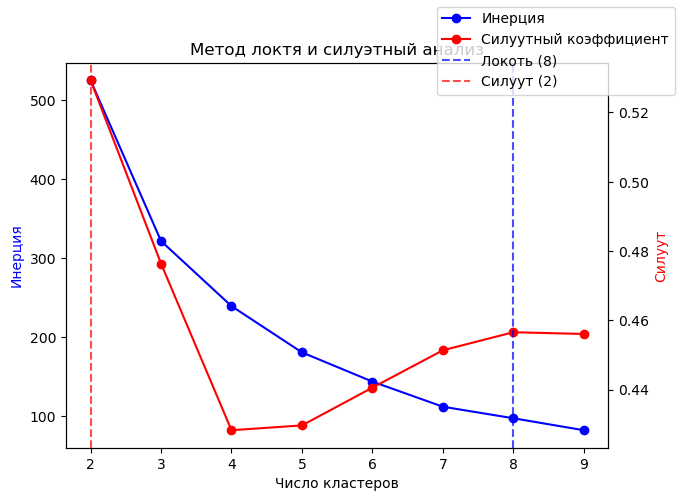

Локоть инерции: 8, Оптимальный силуэт: 2
Выбрано оптимальное число кластеров: 5
Силуэт для DBSCAN 2D: 0.305
Силуэт для DBSCAN 3D: 0.233
Силуэт для KMeans 2D: 0.430
Силуэт для KMeans 3D: 0.402
Силуэт для DBSCAN FIL 2D: 0.305
Силуэт для DBSCAN FIL 3D: 0.314


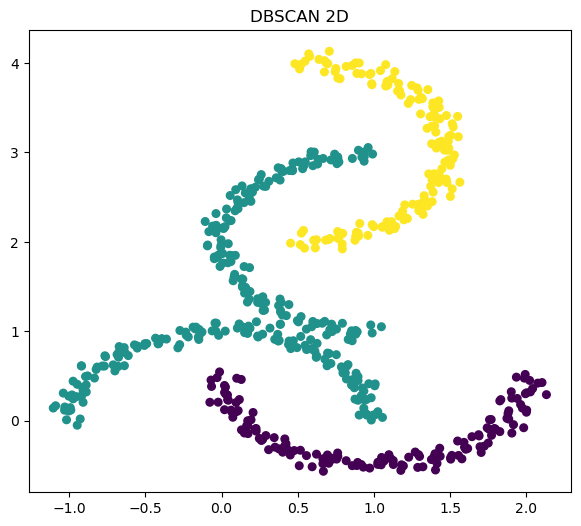

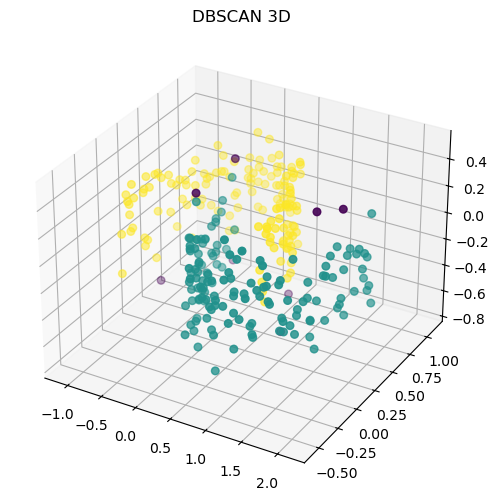

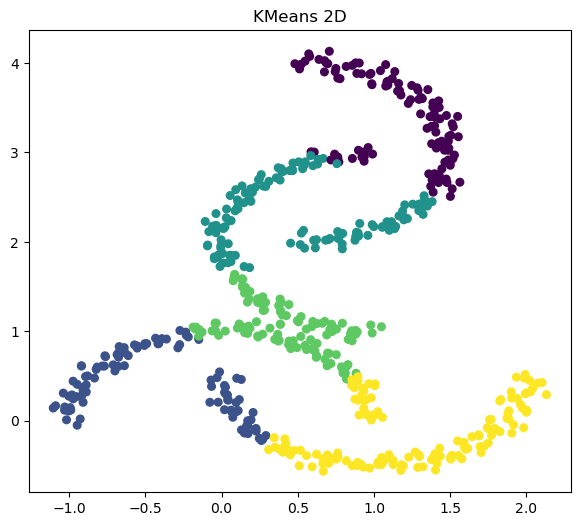

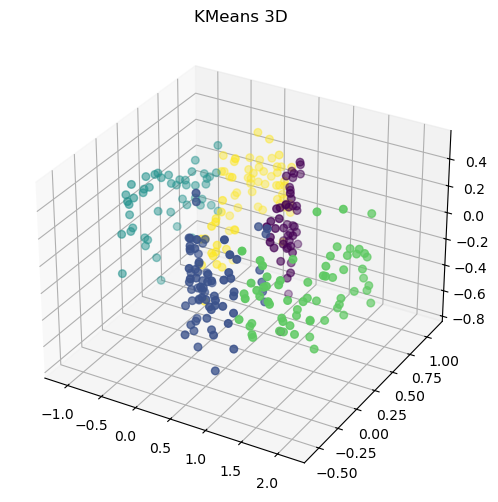

In [76]:

X_2d, y_true_2d, X_3d, y_true_3d = generate_data()
scaler = StandardScaler()

optimal_k = find_optimal_k(X_2d)
labels_2d, labels_3d, labels_kmeans_2d, labels_kmeans_3d = clustering(X_2d, X_3d, optimal_k)

X_2d_filtered = X_2d[labels_2d != -1]
labels_2d_filtered = labels_2d[labels_2d != -1]

X_3d_filtered = X_3d[labels_3d != -1]
labels_3d_filtered = labels_3d[labels_3d != -1]

plot_clusters(X_2d, labels_2d, "DBSCAN 2D")
plot_clusters(X_3d, labels_3d, "DBSCAN 3D", is_3d=True)
plot_clusters(X_2d, labels_kmeans_2d, "KMeans 2D")
plot_clusters(X_3d, labels_kmeans_3d, "KMeans 3D", is_3d=True)


# Отфлитрованный DBSCAN на выбросы

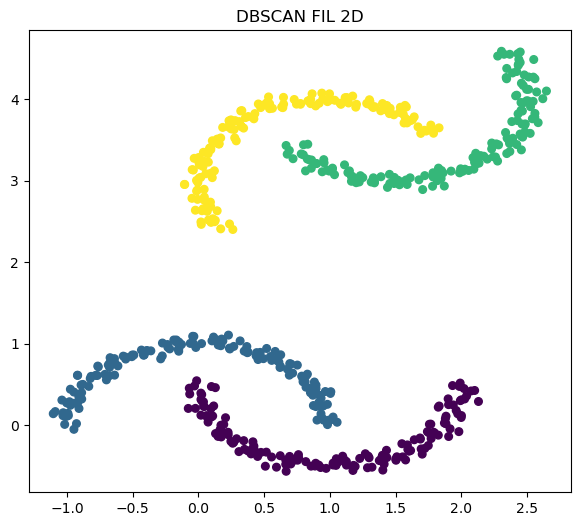

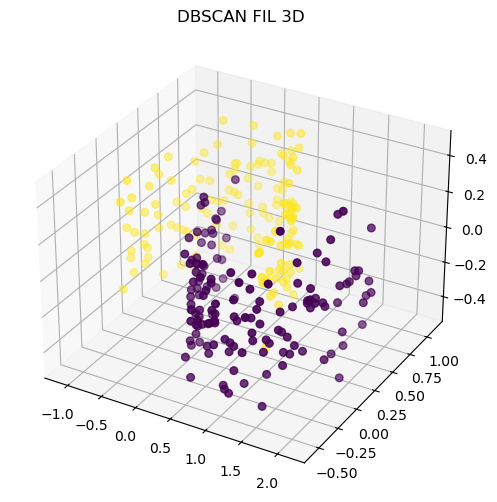

In [57]:
plot_clusters(X_2d_filtered, labels_2d_filtered, "DBSCAN FIL 2D")
plot_clusters(X_3d_filtered, labels_3d_filtered, "DBSCAN FIL 3D", is_3d=True)

Локоть инерции: 3, Оптимальный силуэт: 2 \
Выбрано оптимальное число кластеров: 2 \
Силуэт для DBSCAN 2D: 0.330 \
Силуэт для DBSCAN 3D: 0.218 \
Силуэт для KMeans 2D: 0.643 \
Силуэт для KMeans 3D: 0.460 \
Силуэт для DBSCAN FIL 2D: 0.330 \
Силуэт для DBSCAN FIL 3D: 0.315 